In [1]:
import os
import json
import spacy
import pandas as pd
from tqdm import tqdm
import numpy as np
from spacy.tokens import DocBin

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/NER-Resume/')

In [4]:
!ls

base_config.cfg  datamerged_data.json  phase_1_labels.csv  train_sample.ipynb
config.cfg	 jd.json	       train.ipynb	   train.spacy
data		 output		       train-phase2.ipynb


In [5]:

# out_path = annotations


root_dir = 'data'
data_out = []
for f in os.listdir('data'):
    f_path = os.path.join('data',f)
    print(f'Opening file: {f_path}')
    text = []
    entities = []
    with open(f_path,'rb') as f: 
        data = json.load(f)   
    
    for doc in data:
        annots = {}
        try:
            name = doc["documentName"]
            entities = []
            text = doc['document']
            annotation = doc['annotation']
            for an in annotation:
                entities.append((an['start'],an['end'],an['label']))
            annots['text'] = text
            annots['entities'] = entities
            annots['name'] = name
            annots['resume_name'] = name.split('.')[0][:-2] 
        except:
            name = doc["documentName"]
            entities = []
            text = doc['document']
            annotation = doc['tokens']
            for an in annotation:
                entities.append((an['start'],an['end'],an['entityLabel']))
            annots['text'] = text
            annots['entities'] = entities
            annots['name'] = name
            annots['resume_name'] = name.split('.')[0][:-2] 

        print(f'Processed {annots["resume_name"]} --- {annots["name"]}')
        data_out.append(annots)


Opening file: data/annotations_file.json
Processed abhinav_anand --- abhinav_anand_1.txt_2022-08-03_12:01:45.9.txt
Processed abhinav_anand --- abhinav_anand_0.txt_2022-08-03_12:01:45.3.txt
Processed abhinav --- abhinav_1.txt_2022-08-03_12:01:44.8.txt
Processed abhinav --- abhinav_0.txt_2022-08-03_12:01:44.5.txt
Processed abhina_b --- abhina_b_1.txt_2022-08-03_12:01:44.2.txt
Processed abhina_b --- abhina_b_0.txt_2022-08-03_12:01:43.9.txt
Processed abhimanyu_yadav --- abhimanyu_yadav_1.txt_2022-08-03_12:01:43.5.txt
Processed abhimanyu_yadav --- abhimanyu_yadav_0.txt_2022-08-03_12:01:43.2.txt
Processed abhijeet_soni --- abhijeet_soni_1.txt_2022-08-03_12:01:42.9.txt
Processed abhijeet_soni --- abhijeet_soni_0.txt_2022-08-03_12:01:42.6.txt
Processed abdul --- abdul_0.txt_2022-08-03_12:01:42.1.txt
Processed abdal_attar --- abdal_attar_3.txt_2022-08-03_12:01:41.8.txt
Processed abdal_attar --- abdal_attar_2.txt_2022-08-03_12:01:41.5.txt
Processed abdal_attar --- abdal_attar_1.txt_2022-08-03_12

In [6]:
data_out[14]

{'text': 'ABDAL ATTAR\nBangalore * 9008761939  abadalattar@gmail.com\nOBJECTIVE\nA highly competent data scientist with more than two years of experience\ndeveloping a wide range of innovative applications like Churn Model, Recharge\nLikelihood Model. Ability to use (data) statistics and machine learning for finding\ncomplex data patterns that drive meaningful impact on the business. I am looking\nfor the opportunity to build a challenging career and apply my skills in an\ninnovative and simplify process. I enjoy working in a team and communicating\ndata- driven results.\nWORK EXPERIENCE\nComviva Technologies Nov 2018- Present\nAnalytics Projects\nClient  Ooredoo Kuwait\ne Universal control group \nWorked upon UCG (Universal control group) statistic model development\nfor Indosat in python (K-mean clustering, T-test, Chi squareTest,\nAutomation)\ne Churn Prediction Model Development-\nObjective: The idea is to capture customers those will get churn next\nmonth\nCollected data from clie

**Splitting to train and test**

In [9]:
df = pd.read_csv('phase2_labels.csv')
# print(df.shape)
# df = df.drop_duplicates(subset=['name'])
print(df.shape)
df.head()

(85, 2)


,name,label
0,aakansha_tyagi,1
1,abashes_das,1
2,abdal_attar,1
3,abdul,1
4,abhijeet_soni,0


In [10]:

# 70-30 split
df_train = df[:int(0.7*df.shape[0])]
df_test = df[int(0.7*df.shape[0]):].reset_index(drop=True)

print(df_train.shape,df_test.shape)

(59, 2) (26, 2)


In [11]:
TRAIN_DATA = []
TEST_DATA = []
for d in data_out:
  if d['resume_name'] in df_train['name'].values:
     TRAIN_DATA.append(d)
  else:
     TEST_DATA.append(d)

In [12]:
# ## 80-20 split
# print(f'Length of total data: {len(data_out)}' )
# TRAIN_DATA = data_out[:int(0.8*len(data_out))]
# TEST_DATA = data_out[int(0.8*len(data_out)):]

print(f'Length of train data: {len(TRAIN_DATA)}')
print(f'Length of test data: {len(TEST_DATA)}')

Length of train data: 191
Length of test data: 47


**Getting whole corpus of words in train data**

In [13]:
import re

train_skills = []
for doc in TRAIN_DATA:
  for d in doc['entities']:
    if d[2] == 'SKILLS':
        skill = doc['text'][d[0]:d[1]]
        skill = re.sub('[^A-Za-z0-9]+', ' ', skill.lower())
        skill = skill.strip()
        if skill not in train_skills:
          train_skills.append(skill)

print(train_skills)

['optimization', 'algorithm development', 'recommendation engine', 'loss minimization', 'optimization techniques', 'yield management', 'model performance', 'evaluation metric', 'models', 'sql', 'sql query optimization', 'load balancing', 'analyzing data', 'predictive models', 'machine learning', 'neural network techniques', 'classification', 'regression', 'clustering', 'ml techniques', 'artificial neural network', 'computer vision', 'text analytics', 'deep learning', 'gesture recognition', 'image recognition', 'python', 'pandas', 'logistic regression', 'precision', 'recall', 'nltk', 'natural language processing', 'tensor flow', 'of deep neural network', 'extract information', 'al', 'exploratory data analysis', 'boosting techniques', 'image processing', 'deep neural network', 'classification predictive model', 'random forest', 'data cleaning', 'data manipulation', 'eda', 'data analyzing', 'insights', 'rest apis', 'flask', 'continuous integration', 'jenkins', 'github', 'face mask detecti

In [14]:
#geting skills from jd

with open('jd.json','rb') as f: 
    jd_data = json.load(f)   

jd_skills = []
for d in jd_data[0]['annotation']:
  skill = re.sub('[^A-Za-z0-9]+', ' ', d['text'].lower())
  skill = skill.strip()
  if skill not in jd_skills:
    jd_skills.append(skill)

print(jd_skills)

['data science', 'natural language processing', 'computer vision', 'regression', 'classification', 'unsupervised learning', 'in r', 'python', 'sql', 'machine learning', 'cloud', 'aws', 'microsoft azure', 'gcp', 'containerization', 'docker', 'kubernetes', 'api development', 'flask', 'plumber', 'django', 'celery', 'code versioning', 'github', 'gitlab', 'codecommit', 'tableau', 'redshift', 'dynamodb', 'statistics', 'mathematics', 'computer science', 'java', 'js', 'c', 'nosql', 'continuous integration', 'continuous deployment', 'ci cd experience', 'big data', 'hadoop', 'spark', 'h2o ai', 'data robot']


## Loading data

In [15]:
#nlp = spacy.blank("en") # load a new spacy model
nlp = spacy.load("en_core_web_sm") # load other spacy model
db = DocBin() # create a DocBin object

for d in tqdm(TRAIN_DATA): # data in previous format
    text = d['text']
    annots = d['entities']  
    doc = nlp.make_doc(text) # create doc object from text

    ents = []
    for start, end, label in annots: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    # print(ents)
    doc.ents = ents # label the text with the ents
    db.add(doc)
    
#saving
db.to_disk("./train.spacy")

100%|██████████| 191/191 [00:01<00:00, 145.04it/s]


### Filling the config file

In [16]:
!python -m spacy init fill-config base_config.cfg config.cfg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-18 05:27:34.546229: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


### Run the Training configuration

In [17]:
!python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./train.spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-18 05:28:06.169877: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-12-18 05:28:07,203] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-12-18 05:28:07,215] [INFO] Pipeline: ['tok2vec', 'ner']
INFO:spacy:Pipeline: ['tok2vec', 'ner']
[2022-12-18 05:28:07,219] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-12-18 05:28:07,220] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
[2022-12-18 05:28:10,812] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
INFO:spacy:Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipelin

## Inference

In [19]:
nlp1 = spacy.load(r"output/model-best") #load the best model

text = "Experienced in collecting, analyzing, and interpreting\nlarge datasets, developing software solutions, and performing data management tasks. Possessing extensive analytical skills, strong\nattention to detail and a significant ability to work in team environment.\nTECHNICAL SKILLS 00.2... ccc cece cece eee e eee e eee eens eee eee e eee nena eee eee e eee eee eeeee eee eee eee eeeee esas\ne Packages: Scikit - Learn, Numpy, SciPy, Plot.py, Pandas, NLTK, Matplotlib, Flask, Seaborn\ne Big Data Stack: Python, PostgreSQL, MongoDB, Linux, Hadoop\ne Statistics/ML/NLP: Linear/Logistic Regression, K-Nearest Neighbors, Random Forest, Naive Bayes, Clustering, BERT, GloVE, CNN,\nRNN, MobileNetV2\ne Visualization: Tableau, QlikSense\nPROJECTS"
doc = nlp1(text) # input sample text

spacy.displacy.render(doc, style="ent", jupyter=True) # display in Jupyter

### Perfomance on Test data

In [20]:
def calc_precision(pred, true):        
    precision = len([x for x in pred if x in true]) / (len(pred) + 1e-20) # true positives / total pred
    return precision

def calc_recall(pred, true):
    recall = len([x for x in true if x in pred]) / (len(true) + 1e-20)    # true positives / total test
    return recall

def calc_f1(precision, recall):
    f1 = 2 * ((precision * recall) / (precision + recall + 1e-20))
    return f1

In [21]:
model = spacy.load(r"output/model-best") #load the best model
precisions, recalls, f1s = [], [], []

for data in TEST_DATA:
    doc = data["text"]
    inp_entities = data['entities']

    out = model(doc)
    true_labels = [i[2] for i in inp_entities]
    pred_labels = [i.label_ for i in out.ents]
    # print(out.ents,out.cats)
    precision = calc_precision(true_labels, pred_labels)
    precisions.append(precision)
    recall = calc_recall(true_labels, pred_labels)
    recalls.append(recall)
    f1s.append(calc_f1(precision, recall))
  
print(f'precision: {np.mean(precisions)}')
print(f'Recalls:  {np.mean(recalls)}')
print(f'F1 score:  {np.mean(f1s)}')

precision: 0.9801870583523881
Recalls:  0.9778664302600474
F1 score:  0.9730382153137017


In [ ]:
# for i,data in enumerate(TEST_DATA):
#     doc = data["text"]
#     out = model(doc)
#     spacy.displacy.render(out, style="ent", jupyter=True) # display in Jupyter
#     print('--'*20)
#     if i == 5:
#         break

# Resume screeneer

In [25]:



def generate_one_hot_vec(inp_list):
   one_hot_dict = {i:0 for i in train_skills}

   for i in inp_list:
     if i in one_hot_dict.keys():
        one_hot_dict[i] = 1
   return list(one_hot_dict.values())

def similarity_jd(inp_skills):
    count = 0 
    for i in inp_skills:
      if i in jd_skills:
        count +=1
  
    return count/len(jd_skills)

In [30]:
len(train_skills)

873

In [28]:
len(train_data[0])

876

In [31]:
model = spacy.load(r"output/model-best") #load the best model

train_data = []
for idx, d in df_train.iterrows():
    name,label = d[0],d[1]
    
    # geting text data from doc
    text = ' '.join([d['text'] for d in TRAIN_DATA if d['resume_name'] == name])
    out = model(text)
    predicted_skills = list(out.ents)
  
    skills = [p.text.lower() for p in predicted_skills]
    out_vec = generate_one_hot_vec(skills)
    sim = similarity_jd(skills)
    d = [name,sim] + out_vec + [label]
    train_data.append(d)
    

dff_train = pd.DataFrame(train_data,columns=['name','similarity'] + [f'vec_{i}' for i in range(0,873)] + ['label'])



test_data = []
for idx, d in df_test.iterrows():
    name,label = d[0],d[1]
    
    # geting text data from doc
    text = ' '.join([d['text'] for d in TEST_DATA if d['resume_name'] == name])
    out = model(text)
    predicted_skills = list(out.ents)
  
    skills = [p.text.lower() for p in predicted_skills]
    out_vec = generate_one_hot_vec(skills)
    sim = similarity_jd(skills)
    d = [name,sim] + out_vec + [label]
    test_data.append(d)
    

dff_test = pd.DataFrame(test_data,columns=['name','similarity'] + [f'vec_{i}' for i in range(0,873)] + ['label'])

print(dff_train.shape,dff_test.shape)

(59, 876) (26, 876)


In [32]:
dff_train

,name,similarity,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,...,vec_864,vec_865,vec_866,vec_867,vec_868,vec_869,vec_870,vec_871,vec_872,label
0,aakansha_tyagi,0.181818,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,abashes_das,0.545455,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,abdal_attar,0.545455,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,abdul,0.318182,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,abhijeet_soni,0.500000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,abhimanyu_yadav,0.500000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,abhinav,0.727273,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,abhinav_anand,0.545455,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
8,abhinav_anil,0.136364,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,abhina_b,0.454545,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
X_train = dff_train.drop(columns=['name','label'])
y_train = dff_train['label'] 

X_test = dff_test.drop(columns=(['name','label']))
y_test = dff_test['label']

print(X_train.shape,X_test.shape)


(59, 874) (26, 874)


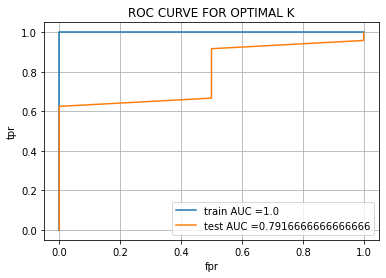

Area under train roc 1.0
Area under test roc 0.7916666666666666


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

model = RandomForestClassifier()
model.fit(X_train,y_train) 

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))



/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


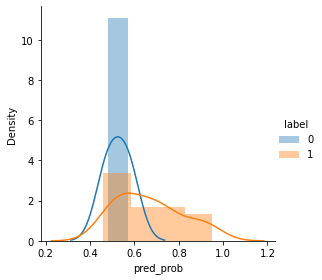

In [35]:
import seaborn as sns
y_pred_prob = model.predict_proba(X_test)[:,1]
df_test['pred_prob'] = y_pred_prob
sns.FacetGrid(df_test,hue='label',size=4).map(sns.distplot,'pred_prob').add_legend()
plt.show()

<ipython-input-36-1bc9b0e472bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['pred_prob'] = y_pred_prob
/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a 

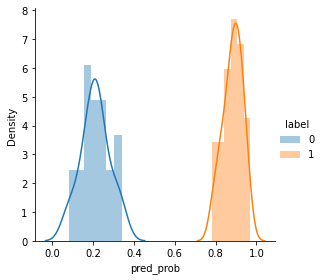

In [36]:
y_pred_prob = model.predict_proba(X_train)[:,1]
df_train['pred_prob'] = y_pred_prob
sns.FacetGrid(df_train,hue='label',size=4).map(sns.distplot,'pred_prob').add_legend()
plt.show()

In [37]:
df_train['label'].value_counts()

1    37
0    22
Name: label, dtype: int64

In [38]:
df_test['label'].value_counts()

1    24
0     2
Name: label, dtype: int64